In [1]:
# !pip install --upgrade-strategy=only-if-needed tensorflow~=1.6.0rc0
# !pip install -U gensim~=3.2.0

In [77]:
import gensim
import gzip
import numpy as np
import os
import pandas as pd
import tensorflow as tf
execfile("./FairAI.py")

In [3]:
local_dir_name = '../data'
WORD2VEC_FILE = os.path.join(local_dir_name+"/embeddings", "GoogleNews-vectors-negative300.bin.gz")
ANALOGIES_FILE = os.path.join(local_dir_name, "questions-words.txt")

In [4]:
%%time
if not 'client' in vars():
  print "Loading word embeddings from %s" % WORD2VEC_FILE
  with gzip.GzipFile(fileobj=open(WORD2VEC_FILE, 'r')) as f:
    client = load_word2vec_format(f, max_num_words=2000000)
embeddings = client

Loading word embeddings from ../data/embeddings/GoogleNews-vectors-negative300.bin.gz
vector_size =  300
Loading 2000000 embeddings
('duplicate words detected, shrinking matrix size from %i to %i', 3000000, 2000000)
('loaded %s matrix', (2000000, 300))
CPU times: user 46.9 s, sys: 1.45 s, total: 48.4 s
Wall time: 48.5 s


## Are there harmful anaolgies with repsect to negative sentiment?

In [5]:
A = "asian"
B = "american"
C = "smart"
NUM_ANALOGIES = 5

in_arr = []
for i, word in enumerate((A, B, C)):
  in_arr.append(client.word_vec(word))
in_arr = np.array([in_arr])

print_knn(client, -in_arr[0, 0, :] + in_arr[0, 1, :] + in_arr[0, 2, :],
          NUM_ANALOGIES)

5 closest neighbors to A-B+C:
smart : score=0.668151
intelligent : score=0.454270
dumb : score=0.442581
smarter : score=0.412079
american : score=0.410000


In [32]:
analogies = load_analogies(ANALOGIES_FILE)
print "\n".join("%s is to %s as %s is to %s" % tuple(x) for x in analogies[-20:])

loaded 19544 analogies
write is to writes as increase is to increases
write is to writes as listen is to listens
write is to writes as play is to plays
write is to writes as predict is to predicts
write is to writes as provide is to provides
write is to writes as say is to says
write is to writes as scream is to screams
write is to writes as search is to searches
write is to writes as see is to sees
write is to writes as shuffle is to shuffles
write is to writes as sing is to sings
write is to writes as sit is to sits
write is to writes as slow is to slows
write is to writes as speak is to speaks
write is to writes as swim is to swims
write is to writes as talk is to talks
write is to writes as think is to thinks
write is to writes as vanish is to vanishes
write is to writes as walk is to walks
write is to writes as work is to works


In [33]:
embed, indices, words = load_vectors(client, analogies)

embed_dim = len(embed[0].flatten())
print "word embedding dimension: %d" % embed_dim

found 905 unique words
words not filtered out: 905
word embedding dimension: 300


In [8]:
pos_words = load_lexicon("../data/opinion_lexicon/positive-words.txt")
neg_words = load_lexicon("../data/opinion_lexicon/negative-words.txt")
pos_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,pos_words))
neg_words_fil = filter(lambda x:  x in embeddings,map(lambda x: x,neg_words))
pos_vectors = embeddings[pos_words_fil]
neg_vectors = embeddings[neg_words_fil]
vectors = np.concatenate([pos_vectors, neg_vectors])
targets = np.array([0 for entry in pos_vectors] + [1 for entry in neg_vectors])
train_vectors, test_vectors, train_targets, test_targets = train_test_split(vectors, targets, test_size=0.1, random_state=0)

In [9]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='auto').fit(train_vectors,train_targets)
clf.score(test_vectors,test_targets)


0.946031746031746

<BarContainer object of 100 artists>

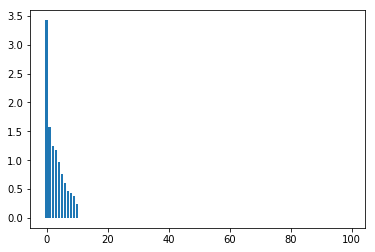

In [10]:
import nltk 
from nltk.corpus import wordnet 
good = []
bad=  []

for word in pos_words:
    a = wordnet.synsets(word)
    if len(a)>0:
        syn = a[0] .lemmas()[0]
        if len(syn.antonyms())>0:
            good.append(word)
            bad.append(syn.antonyms()[0].name()) 
            
good_vectors=[]
bad_vectors = []
good = ['good','beautiful','happy','positive','compentent','smart','interesting','pleasant','best','honest','wealthy','wonderful']
bad = ['bad','ugly','sad','negative','incompetent','dumb','boring','horrible','worst','corrupt','poor','awful']
# good = ['amazing']
# bad = ['horrible']
choices = np.random.choice(len(good),20)
for i,j in zip(good,bad):
    if i in embeddings and j in embeddings:
        good_vectors.append(_np_normalize(embeddings[i]))
        bad_vectors.append(_np_normalize(embeddings[j]))

good_vectors = np.array(good_vectors)
bad_vectors = np.array(bad_vectors)
X = good_vectors-bad_vectors
m = np.dot(X.T,X)
evals, evecs = np.linalg.eig(m)
vec = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.bar(np.arange(100),evals[:100])

## create sentiment subspace via our method

<BarContainer object of 100 artists>

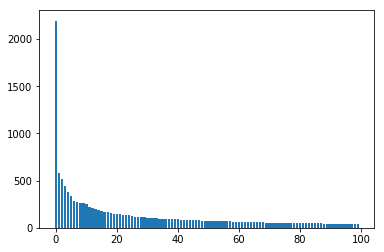

In [11]:
m=np.dot(pos_vectors.T,pos_vectors)
evals, evecs = np.linalg.eig(m)
vec_pos = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(100),evals[:100])

In [12]:
neg_vectors=neg_vectors[np.random.choice(len(pos_vectors),len(pos_vectors))]

<BarContainer object of 100 artists>

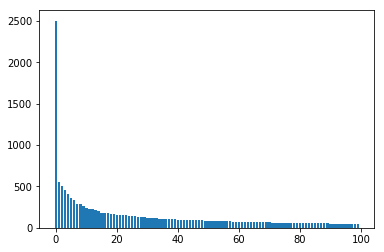

In [13]:
m=np.dot(neg_vectors.T,neg_vectors)
evals, evecs = np.linalg.eig(m)
vec_neg = _np_normalize(np.real(evecs[:, np.argmax(evals)]))
plt.figure()
plt.bar(np.arange(100),evals[:100])

In [14]:
##get direcitonal sentiment vector
vec=vec_pos-vec_neg

In [15]:
WORD = "bad"
word_vec = _np_normalize(client.word_vec(WORD))
print vec.dot(word_vec.T)

-0.1981475


## how does the sign of projection correlate with positive/negative labels

In [16]:
count = 0 
for i,j in zip(vectors,(targets*2-1)*-1):
    if int(np.sign(i.dot(vec))) == j:
        count+=1
print count/float(len(targets))

0.918558501349


## define set of identity terms

In [17]:
identities = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 
              'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 
              'female', 'nonbinary', 'african', 'african american', 'black', 'white', 
              'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 
              'american', 'asian', 'indian', 'middle eastern', 'chinese', 'japanese', 
              'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 
              'taoist', 'old', 'older', 'young', 'younger', 'teenage', 'millenial', 'middle aged', 
              'elderly', 'blind', 'deaf', 'paralyzed']
nationalities=[
'German',
#'African_American',
'Mexican',
'Irish',
'English',
'American',
'Italian',
'Polish',
'French',
'Scottish',
#'Puerto_Rican',
'Norwegian',
'Dutch',
'Swedish',
'Chinese',
'Indian',
'Russian',
'Filipino'
]
religions =[ 
    'Zionist',
    'Catholic',
    'Christian',
    'Islamic',
    'Protestant',
#     'Taoist',
    'Atheist',
    'Hindu',
    'Buddhist',
#     'Diasporic',
    'Sikh',
#     'Juche',
    'Jewish',
#     'Bahai',
#     'Jains',
#     'Shinto',
#     'Pagan'
]
gender= ["male","female","her","him","man","woman","boy","girl","his","hers","mom","dad"]#perhaps try all terms intraprotected group

In [18]:
words = filter(lambda x: x.lower() in embeddings,religions)
df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: embeddings[w.lower()].dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df

         word  sentiment_score
3     Islamic        -0.592810
6       Hindu        -0.583354
0     Zionist        -0.565394
9      Jewish        -0.486161
5     Atheist        -0.367232
2   Christian        -0.310986
8        Sikh        -0.198845
4  Protestant        -0.186069
1    Catholic        -0.103218
7    Buddhist         0.043795


Let's now look at the words with the largest *negative* projection onto the sentiment dimension.

In [19]:
words = set()
for a in analogies:
  words.update(a)

df = pd.DataFrame(data={"word": list(words)})
df["sentiment_score"] = df["word"].map(
    lambda w: client.word_vec(w).dot(vec))
df.sort_values(by="sentiment_score", inplace=True)
print df.head(10)


              word  sentiment_score
579  irresponsible        -0.828594
743      dishonest        -0.811229
217     irrational        -0.777521
428     uninformed        -0.741356
508      unethical        -0.724497
503   unacceptable        -0.662650
304   unproductive        -0.647219
83       illogical        -0.632864
31           worse        -0.629943
380    inefficient        -0.579699


Let's now look at the words with the largest *positive* projection onto the sentiment dimension.

In [20]:
df.sort_values(by="sentiment_score", inplace=True, ascending=False)
print df.head(10)

           word  sentiment_score
206     amazing         0.796999
43   impressive         0.793533
370    sweetest         0.761036
371    tasteful         0.715041
115       great         0.677561
14     tastiest         0.658577
863       tasty         0.629917
328    pleasant         0.629725
711      widest         0.572403
283   fortunate         0.571714


In [26]:
tf.reset_default_graph()

In [34]:
analogy_indices = filter_analogies(analogies, indices)
data, labels, protect = make_data(analogy_indices, embed, vec)
np.shape(data),np.shape(labels),np.shape(protect)

((19544, 3, 300), (19544, 300), (19544, 1))

In [35]:
labels  = embeddings.syn0norm

In [36]:
%%time
protect=[]
for i in labels:
    protect.append(i.dot(vec))

CPU times: user 1.3 s, sys: 32 ms, total: 1.34 s
Wall time: 1.34 s


In [37]:
len(protect)

2000000

In [38]:
w_h=[]

In [78]:
%%time
# Edit the training parameters below to experiment with different training runs.
# For example, try 
pred_learning_rate = 2**-16
protect_learning_rate = 2**-16
# protect_loss_weight = 0.5
num_steps = 2000
batch_size = 1000

embed_dim = 300
projection_dims = 1


sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
with tf.variable_scope('var_scope', reuse=tf.AUTO_REUSE):
    weights = [.5,1,2,4,8,16]
    for i in weights:
        print "weights", i
        protect_loss_weight = i
        analogy_indices = filter_analogies(analogies, indices)

        data, labels, protect = make_data(analogy_indices, embed, vec)
        data_p = tf.placeholder(tf.float32, shape=[None, 3, embed_dim], name="data")
        labels_p = tf.placeholder(tf.float32, shape=[None, embed_dim], name="labels")
        protect_p = tf.placeholder(tf.float32, shape=[None, 1], name="protect")

        # projection is the space onto which we are "projecting". By default, this is
        # one-dimensional, but this can be tuned by projection_dims
        projection = tf.get_variable("projection", [embed_dim, projection_dims])

        # build the prediction layer
        # pred is the simple computation of d = -a + b + c for a : b :: c : d
        pred = labels_p #-data_p[:, 0, :] + data_p[:, 1, :] + data_p[:, 2, :]
        pred -= tf.matmul(tf.matmul(pred, projection), tf.transpose(projection))

        trained_model = AdversarialEmbeddingModel(
            client, data_p, embed_dim, projection, projection_dims, pred,verbose=True)
        trained_model.fit(sess, data, data_p, labels, labels_p, protect, protect_p, vec,
                  pred_learning_rate,
                protect_learning_rate, protect_loss_weight, num_steps, batch_size)
        w=None
        with sess.as_default(): w= trained_model.projection.eval()
        w_h.append(w)
        for j in [nationalities,religions]:
            print j[0]
            words = j
            a=map(lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)

            a=map(lambda a: embeddings[a.lower()].dot(vec),words)
            print np.sum(np.array(a)**2)/len(a)
            
        print evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

weights 0.5
step: 0; pred_loss_o: 0.000031; protect_loss_o: 0.008983
proj_o: 1.404693; dot(proj_o, gender_direction): -0.041991)
step: 1000; pred_loss_o: 0.000029; protect_loss_o: 0.006403
proj_o: 1.389454; dot(proj_o, gender_direction): -0.041965)
German
0.04799190163612366
0.04826413094997406
Zionist
0.11969680786132812
0.1566053032875061
((0.6236551724018544, 1.94588498268058e-39), SpearmanrResult(correlation=0.6587563993926975, pvalue=2.7122695736724004e-45), 0.0)
weights 1
step: 0; pred_loss_o: 0.000056; protect_loss_o: 0.009918
proj_o: 1.415829; dot(proj_o, gender_direction): 0.054883)
step: 1000; pred_loss_o: 0.000080; protect_loss_o: 0.007505
proj_o: 1.461442; dot(proj_o, gender_direction): -0.002498)
German
0.04326329380273819
0.04826413094997406
Zionist
0.14115452766418457
0.1566053032875061
((0.6241851468113366, 1.607755241956869e-39), SpearmanrResult(correlation=0.6606445511587904, pvalue=1.2471400448269127e-45), 0.0)
weights 2
step: 0; pred_loss_o: 0.000047; protect_loss_o

In [ ]:
#save weights
import pickle
with open('p.pkl', 'wb') as f:
    pickle.dump(w_h, f)

In [ ]:
#optionally read weights

# w_h = []
# with (open('p.pkl', "rb")) as openfile:
#     while True:
#         try:
#             w_h.append(pickle.load(openfile))
#         except EOFError:
#             break

## Test adversarial debiasing for real world applications

In [43]:
df = pd.read_csv("../data/kaggle_toxicity/train.csv")
def generate_train_test_set(model,targets,sentences,limit=1000,dim=300):
    vectors = []
    labels = []
    count=0
    for i,sentence in enumerate(sentences):
        words = filter(lambda x: x in model,[x.lower() for x in sentence.split()])
        if len(words)<5 and len(words)>1:
            vectors.append(np.mean(model[words],axis = 0))
            labels.append(targets[i])
            count+=1
    print count, " sentences in embeddings, ", limit - count, " sentences not in embeddings"
    return train_test_split(np.array(vectors), np.array(labels), test_size=0.1, random_state=0)

toxic_sentences = df[df["toxic"]==1]["comment_text"]
num_toxic_samples = len(toxic_sentences)
non_toxic_sentences = df[df["toxic"]==0]["comment_text"].sample(num_toxic_samples)
sentences = pd.concat([toxic_sentences, non_toxic_sentences])
targets  = np.zeros(num_toxic_samples*2)
targets[num_toxic_samples:] = 1
train_vectors, test_vectors, train_targets, test_targets = generate_train_test_set(embeddings,targets,sentences,limit=num_toxic_samples*2 ,dim=300)

2582  sentences in embeddings,  28006  sentences not in embeddings


In [45]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=4, solver='lbfgs',
                         multi_class='multinomial',)
model.fit(train_vectors, train_targets)
preds = model.predict(test_vectors)
# accuracy
(preds == test_targets).mean()

0.8687258687258688

/home/csweeney/.local/lib/python2.7/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "upper middle". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(self.codes)))


(0.5, 0.95)

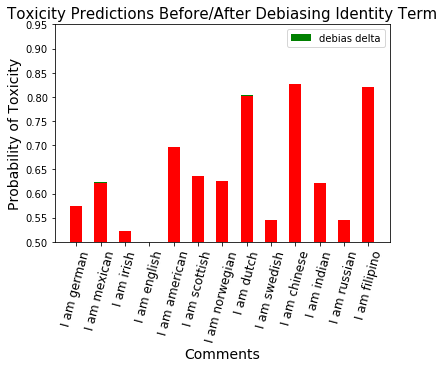

In [47]:
s=[]
for i in nationalities:
    if i.lower() not in ["italian","french","polish"]:
        s.append("I am " +i.lower())
p=[]
d=[]
for i in s:
    n=2
    a =i.split(" ")
    p.append(model.predict_proba([np.mean(embeddings[a],axis=0)])[0][0])
    de = embeddings[a]
    de[n,:] = embeddings[a[n]]-(np.dot(np.dot(w_h[0][4],w_h[0][4].T),embeddings[a[n]]))
    d.append((model.predict_proba([np.mean(de,axis=0)])[0][0]))

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,p,width=.5,color='g',label="debias delta")
plt.xticks(index, s, fontsize=12, rotation=75)
plt.ylim(top=1,bottom=.3)

# plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before/After Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,d,width=.5,color='r')
plt.xticks(index, s, fontsize=12, rotation=75)
plt.legend(loc='upper middle')
plt.ylim(top=.95,bottom=.5)

(0, 1)

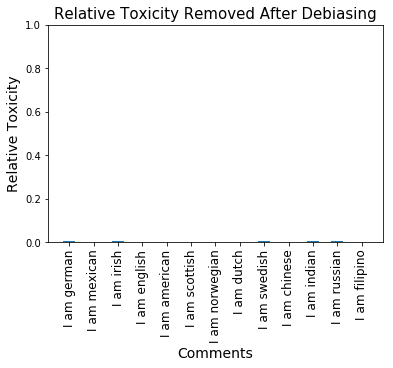

In [48]:
plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Relative Toxicity', fontsize=14)
plt.title("Relative Toxicity Removed After Debiasing",fontsize= 15)
index = np.arange(13)
delta = np.abs(p)-np.abs(d)
plt.bar(index,np.array(delta)/(np.array(p)-.5),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)

# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, s, fontsize=12, rotation=90)
plt.ylim(top=1,bottom=0)

(0, 1)

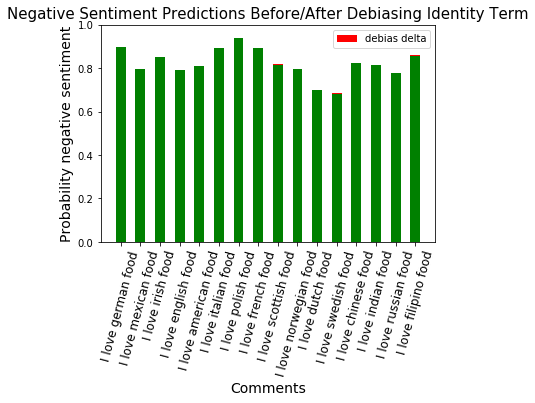

In [49]:
s=[]
for i in nationalities:
    s.append("I love " + i.lower() + " food")
p=[]
d=[]
for i in s:
    n=1
    a =i.split(" ")
    p.append(clf.predict_proba([np.mean(embeddings[a],axis=0)])[0][0])
    de = embeddings[a]
    de[n,:] = embeddings[a[n]]-(np.dot(np.dot(w_h[0][4],w_h[0][4].T),embeddings[a[n]]))
    d.append((clf.predict_proba([np.mean(de,axis=0)])[0][0]))

plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability of Toxicity', fontsize=14)
plt.title("Toxicity Predictions Before Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,p,width=.5,color='r',label="debias delta")
plt.xticks(index, s, fontsize=12, rotation=75)
plt.ylim(top=1,bottom=0)

# plt.figure()
plt.xlabel('Comments', fontsize=14)
plt.ylabel('Probability negative sentiment', fontsize=14)
plt.title("Negative Sentiment Predictions Before/After Debiasing Identity Term",fontsize= 15)
index = np.arange(len(s))
bar = plt.bar(index,d,width=.5,color='g')
plt.xticks(index, s, fontsize=12, rotation=75)
plt.legend(loc='upper right')
plt.ylim(top=1,bottom=0)

## Evaluate Word Embeddings before and after debiasing

In [50]:
table = {}
table1 = {}
for i in analogies:
    for j in i:
        if not j in table:
            table[j.lower()] = 1
            table1[j.lower()] = [i]
        else: 
            table1[j.lower()].append(i)
            table[j.lower()]+=1

In [51]:
for i in nationalities:
    if i.lower() in table1:
        print table1[i.lower()],i

[['Ukraine', 'Ukrainian', 'Germany', 'German']] German
[['Ukraine', 'Ukrainian', 'Mexico', 'Mexican']] Mexican
[['Ukraine', 'Ukrainian', 'Ireland', 'Irish']] Irish
[['Ukraine', 'Ukrainian', 'England', 'English']] English
[['Ukraine', 'Ukrainian', 'Italy', 'Italian']] Italian
[['Ukraine', 'Ukrainian', 'Poland', 'Polish']] Polish
[['Ukraine', 'Ukrainian', 'France', 'French']] French
[['Ukraine', 'Ukrainian', 'Norway', 'Norwegian']] Norwegian
[['Ukraine', 'Ukrainian', 'Netherlands', 'Dutch']] Dutch
[['Ukraine', 'Ukrainian', 'Sweden', 'Swedish']] Swedish
[['Ukraine', 'Ukrainian', 'China', 'Chinese']] Chinese
[['Ukraine', 'Ukrainian', 'India', 'Indian']] Indian
[['Ukraine', 'Ukrainian', 'Russia', 'Russian']] Russian


In [52]:
for i in nationalities:
    if i.lower() in table:
        print table[i.lower()],i

1 German
1 Mexican
1 Irish
1 English
1 Italian
1 Polish
1 French
1 Norwegian
1 Dutch
1 Swedish
1 Chinese
1 Indian
1 Russian


In [54]:
w=None
with sess.as_default():
    
#     w= trained_model.projection.eval()
    w= w_h[0]

In [55]:
client.similar_by_vector(embeddings['amazing'])

[(u'amazing', 1.0),
 (u'incredible', 0.9054001569747925),
 (u'awesome', 0.8282865285873413),
 (u'unbelievable', 0.8201264142990112),
 (u'fantastic', 0.7789870500564575),
 (u'phenomenal', 0.7642048001289368),
 (u'astounding', 0.7347068786621094),
 (u'wonderful', 0.7263180017471313),
 (u'unbelieveable', 0.716508150100708),
 (u'remarkable', 0.7095627188682556)]

In [56]:
client.similar_by_vector(embeddings['american'])

[(u'american', 0.9999999403953552),
 (u'america', 0.7169357538223267),
 (u'americans', 0.6877551078796387),
 (u'british', 0.6732469201087952),
 (u'indian', 0.659941554069519),
 (u'canadian', 0.6264656186103821),
 (u'chinese', 0.6219790577888489),
 (u'european', 0.6148862242698669),
 (u'mexican', 0.6054090261459351),
 (u'african', 0.603766679763794)]

In [57]:
client.similar_by_vector(embeddings['american']-np.dot(np.dot(w,w.T),embeddings['american']))

[(u'american', 0.9937730431556702),
 (u'america', 0.7114443778991699),
 (u'americans', 0.6860173344612122),
 (u'british', 0.6607521772384644),
 (u'indian', 0.6553095579147339),
 (u'canadian', 0.6171302795410156),
 (u'chinese', 0.6158320307731628),
 (u'european', 0.6070958375930786),
 (u'mexican', 0.5970399975776672),
 (u'african', 0.5964952707290649)]

In [58]:
words= filter(lambda x: x.lower() in embeddings,nationalities)

0.04826413094997406


<Figure size 432x288 with 0 Axes>

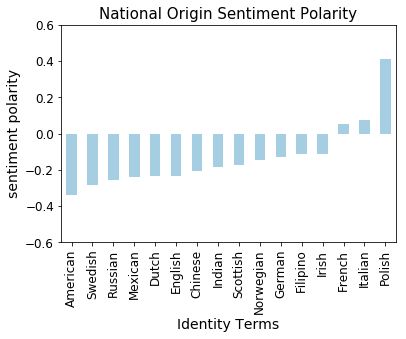

In [63]:
with sess.as_default():

    df1 = pd.DataFrame(data={"Identity Terms": list(words)})
    df1["sentiment polarity"] = df1["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
    df1.sort_values(by="sentiment polarity", inplace=True)
    plt.figure()
    df1.plot.bar(legend = False, ylim= (-.6,.6),x="Identity Terms",y="sentiment polarity",title= "Debiased Religion Sentiment Polarity",fontsize=12, colormap='Paired')
    plt.xlabel('Identity Terms', fontsize=14)
    plt.ylabel('sentiment polarity', fontsize=14)
    plt.title("National Origin Sentiment Polarity",fontsize= 15)
a=map(lambda a: (embeddings[a.lower()]).dot(vec),words)
print np.sum(np.array(a)**2)/len(a)

In [60]:
words= df1["Identity Terms"].values

0.0480799600481987


<Figure size 432x288 with 0 Axes>

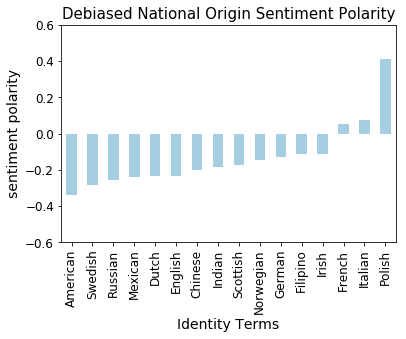

In [62]:
w= w_h[0][4]
with sess.as_default():

    df = pd.DataFrame(data={"Identity Terms": list(words)})
    df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
#     df.sort_values(by="sentiment polarity", inplace=True)
    plt.figure()
    df.plot.bar(legend = False, ylim= (-.6,.6),x="Identity Terms",y="sentiment polarity",title= "Debiased Religion Sentiment Polarity",fontsize=12, colormap='Paired')
    plt.xlabel('Identity Terms', fontsize=14)
    plt.ylabel('sentiment polarity', fontsize=14)
    plt.title("Debiased National Origin Sentiment Polarity",fontsize= 15)
a=map(lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec),words)
print np.sum(np.array(a)**2)/len(a)

(-0.6, 0.6)

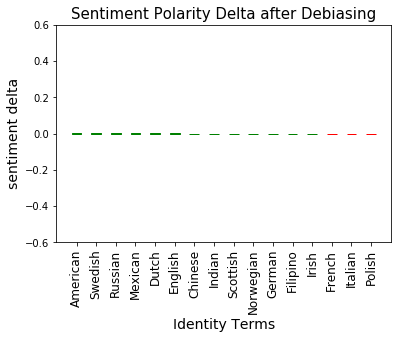

In [64]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('sentiment delta', fontsize=14)
plt.title("Sentiment Polarity Delta after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = df["sentiment polarity"].values-df1["sentiment polarity"].values
bar = plt.bar(index,delta,width=.5)
for i,j in enumerate(delta):
    bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=.6,bottom=-.6)

(0, 1)

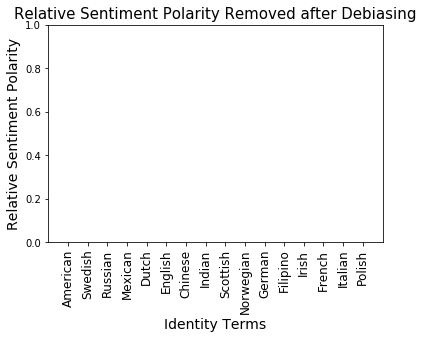

In [65]:
plt.figure()
plt.xlabel('Identity Terms', fontsize=14)
plt.ylabel('Relative Sentiment Polarity', fontsize=14)
plt.title("Relative Sentiment Polarity Removed after Debiasing",fontsize= 15)
index = np.arange(len(words))
delta = np.abs(df1["sentiment polarity"].values)-np.abs(df["sentiment polarity"].values)
plt.bar(index,delta/np.abs(df1["sentiment polarity"].values),width=.5)
# plt.bar(index,df["sentiment polarity"].values,width=.5)
# for i,j in enumerate(delta):
#     bar[i].set_color('r') if j<0 else bar[i].set_color('g')
plt.xticks(index, words, fontsize=12, rotation=90)
plt.ylim(top=1,bottom=0)

## evaluate gender toxicity/negative sentiment distributions

In [71]:
import seaborn
# name_occurence.sort_values(ascending=True,by="toxicity")
male = ["male","him","man","boy","his","father","dad","men"]
female= ["female","her","woman","girl","hers","mother","mom","women"]

<IPython.core.display.Javascript object>


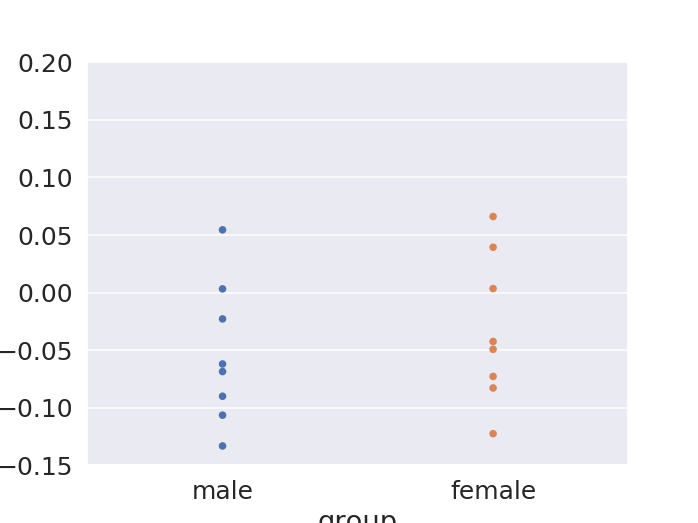

(-0.15, 0.2)

In [72]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()]-(np.dot(np.dot(w,w.T),embeddings[a.lower()]))).dot(vec))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.15, .2])


<IPython.core.display.Javascript object>


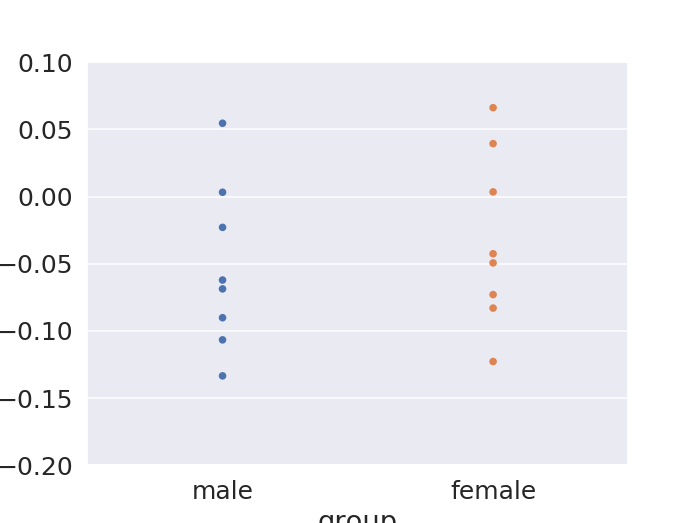

(-0.2, 0.1)

In [73]:
seaborn.set(font_scale=1.5)
frames = []
df = pd.DataFrame(data={"Identity Terms": list(male)})
df["sentiment polarity"] = df["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df['group'] = "male"
frames.append(df)
df_g = pd.DataFrame(data={"Identity Terms": list(female)})
df_g["sentiment polarity"] = df_g["Identity Terms"].map(
        lambda a: (embeddings[a.lower()].dot(vec)))
# toxicity = pd.DataFrame({'sentiment polarity': toxicities}, index=male)
df_g['group'] = "female"
frames.append(df_g)

o = pd.concat(frames)
%matplotlib nbagg
plot = seaborn.swarmplot(x='group', y="sentiment polarity", data=o)
plot.set_ylim([-.2, .1])

0.20355020222002063
0.2775666800500944


<IPython.core.display.Javascript object>


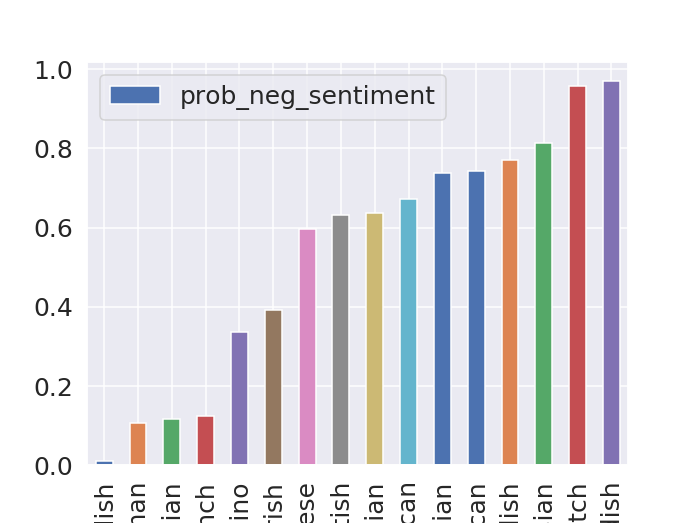

In [74]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda w: clf.predict_proba([embeddings[w.lower()]])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)
df.plot.bar(x="word",y="prob_neg_sentiment")


0.20318198136483467
0.27726869360041706


<IPython.core.display.Javascript object>


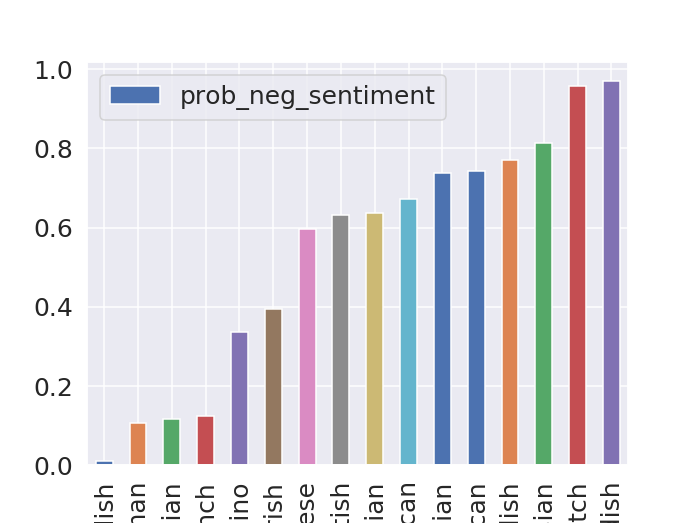

In [75]:
df = pd.DataFrame(data = {"word": list(words)})
df["prob_neg_sentiment"] = df["word"].map(
    lambda a: clf.predict_proba([(embeddings[a.lower()]-np.dot(np.dot(w,w.T),embeddings[a.lower()]))])[0][1])
df.sort_values(by="prob_neg_sentiment", inplace=True)
a= list(df["prob_neg_sentiment"])
uniform_dist = np.ones(len(a))*1./len(a)
normalized = a/np.sum(a)
kl = (normalized * np.log(normalized/uniform_dist)).sum()
print kl
print np.sum(np.abs(np.array(a)-.5))/len(a)

df.plot.bar(x="word",y="prob_neg_sentiment")

## test wordsim accruacy on debiased word embeddings

In [69]:
evaluate_word_pairs(model=embeddings,pairs="../data/sim/sim.tsv",restrict_vocab=2000000,debias=lambda x :x)

((0.6238773451304681, 1.7963247628700625e-39),
 SpearmanrResult(correlation=0.6589215888009288, pvalue=2.5346056459149263e-45),
 0.0)

## test analogy accruacy on debiased word embeddings

In [70]:
(X,y,l) = load_vectors_test(embeddings,analogies)
analogy_accuracy(X,l,embeddings,n = 1,samples=100,model=lambda x :(x-(np.dot(np.dot(w,w.T),x))))

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


0.21